# T11 - Advanced features

This tutorial covers advanced features of Covasim, including custom population options and changing the internal computational methods.

<div class="alert alert-info">
    
Click [here](https://mybinder.org/v2/gh/institutefordiseasemodeling/covasim/HEAD?urlpath=lab%2Ftree%2Fdocs%2Ftutorials%2Ftut_advanced.ipynb) to open an interactive version of this notebook.
    
</div>

## Defining populations with SynthPops

For complex populations, we suggest using [SynthPops](http://synthpops.org), a Python library designed specifically for this purpose. In contrast the population methods built-in to Covasim, SynthPops uses data to produce synthetic populations that are statistically indistinguishable from real ones. For a relatively complex example of how SynthPops was used to create a complex school network for the Seattle region, see [here](https://github.com/institutefordiseasemodeling/testing-the-waters/blob/main/covasim_schools/school_pop.py).

## Defining contact layers

As mentioned in Tutorial 4, contact layers are the graph connecting the people in the simulation. Each person is a node, and each contact is an edge. While enormous complexity can be used to define realistic contact networks, a reasonable approximation in many cases is random connectivity, often with some age assortativity. Here is an example for generating a new contact layer, nominally representing public transportation, and adding it to a simulation:

Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM
Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM
Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM


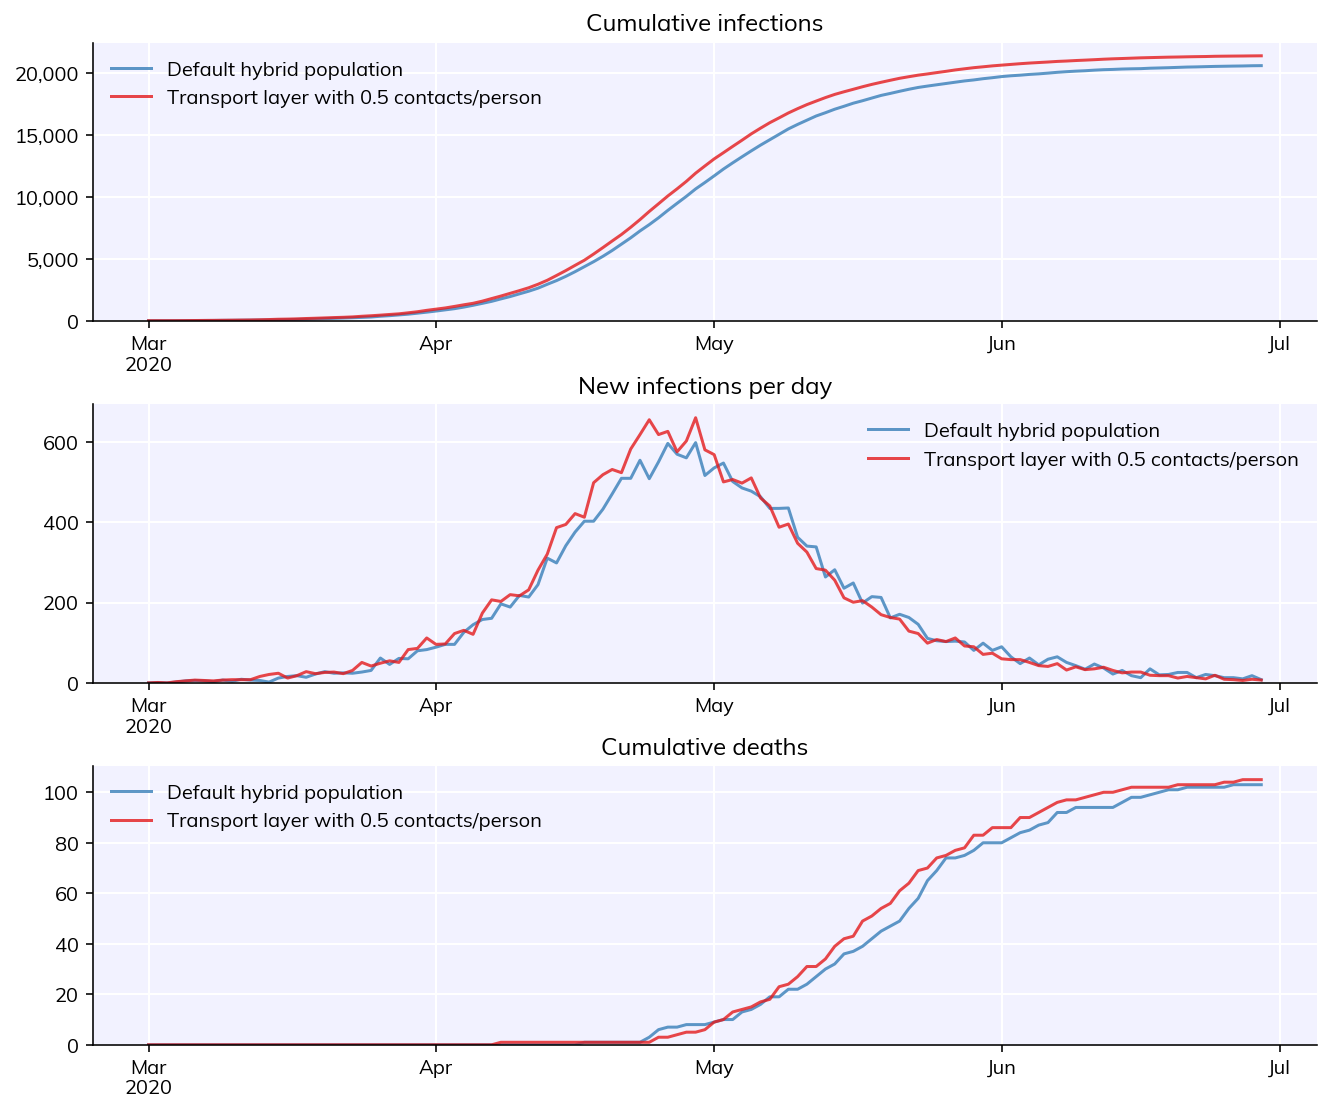

In [1]:
import numpy as np
import covasim as cv
cv.options(jupyter=True, verbose=0)

# Create the first sim
orig_sim = cv.Sim(pop_type='hybrid', n_days=120, label='Default hybrid population')
orig_sim.initialize() # Initialize the population

# Create the second sim
sim = orig_sim.copy()

# Define the new layer, 'transport'
n_people = len(sim.people)
n_contacts_per_person = 0.5
n_contacts = int(n_contacts_per_person*n_people)
contacts_p1 = cv.choose(max_n=n_people, n=n_contacts)
contacts_p2 = cv.choose(max_n=n_people, n=n_contacts)
beta = np.ones(n_contacts)
layer = cv.Layer(p1=contacts_p1, p2=contacts_p2, beta=beta) # Create the new layer

# Add this layer in and re-initialize the sim
sim.people.contacts.add_layer(transport=layer)
sim.reset_layer_pars() # Automatically add layer 'transport' to the parameters using default values
sim.initialize() # Reinitialize
sim.label = f'Transport layer with {n_contacts_per_person} contacts/person'

# Run and compare
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot()

## Defining dynamic layers

You can also define custom layers that update dynamically, e.g. based on a supplied number of contacts per day. To do this, create a new `Layer` class and define the `update()` method. For example:

Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM
Initializing sim with 1000 people for 90 days
Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM
Initializing sim with 1000 people for 90 days
  Running "Default simulation": 2020-03-01 ( 0/90) (0.02 s)  ———————————————————— 1%
  Running "Default simulation": 2020-03-11 (10/90) (0.03 s)  ••—————————————————— 12%
  Running "Default simulation": 2020-03-21 (20/90) (0.05 s)  ••••———————————————— 23%
  Running "Default simulation": 2020-03-31 (30/90) (0.06 s)  ••••••—————————————— 34%
  Running "Default simulation": 2020-04-10 (40/90) (0.08 s)  •••••••••——————————— 45%
  Running "Default simulation": 2020-04-20 (50/90) (0.09 s)  •••••••••••————————— 56%
  Running "Default simulation": 2020-04-30 (60/90) (0.11 s)  •••••••••••••——————— 67%
  Running "Default simulation": 2020-05-10 (70/90) (0.12 s)  •••••••••••••••————— 78%
  Running "Default simulation": 2020-05-20 (80/90) (0.14 s)  •••••••••••••••••——— 89%
  Running "Default simulation": 2020-05

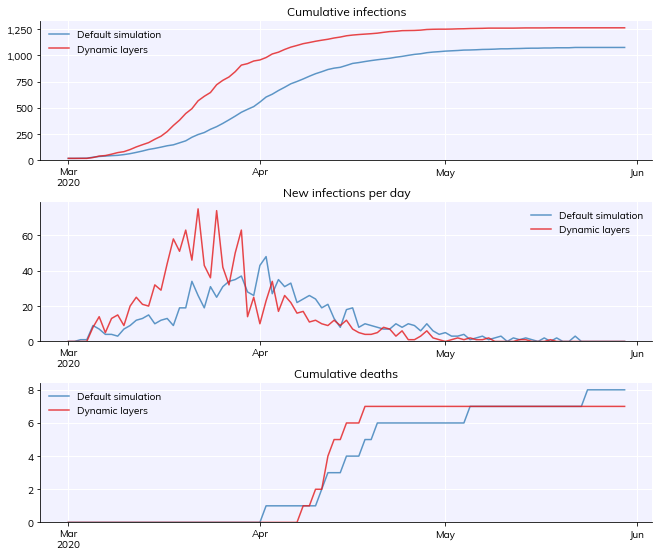

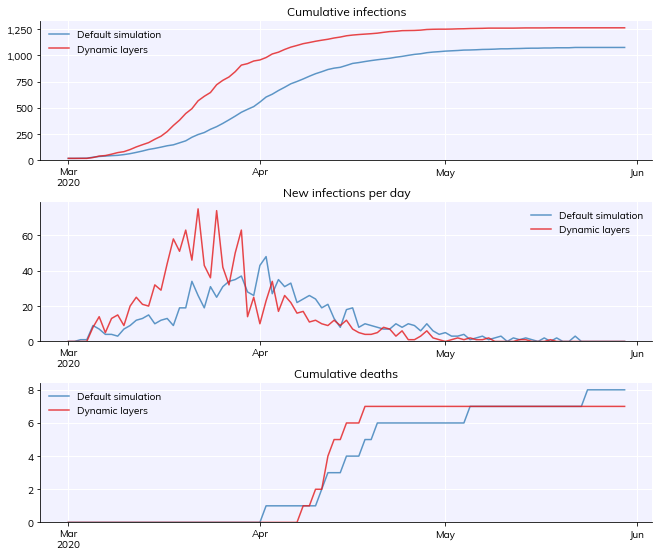

In [1]:
import covasim as cv
import numpy as np
import sciris as sc
from my_layers import *
# Define some simple parameters
pars = sc.objdict(
    pop_size = 1000,
    n_days = 90,
)

# Set up and run the simulation
base_sim = cv.Sim(pars, label='Default simulation')
sim = cv.Sim(pars, dynam_layer=True, label='Dynamic layers')
sim.initialize()

# Update to custom layer
for key in sim.layer_keys():
    contact_data = np.random.randint(pars.pop_size*10, pars.pop_size*20, size=pars.n_days+1) # Generate a number of contacts for today
    sim.people.contacts[key] = CustomLayer(sim.people.contacts[key], contact_data=contact_data)

# Run and plot
msim = cv.parallel(base_sim, sim)
msim.plot()

## Defining custom population properties

Another useful feature is adding additional features to people, for use in subtargeting. For example, this example shows how to define a subpopulation with higher baseline mortality rates. This is a simple example illustrating how you would identify and target people based on whether or not the have a prime-number index, based on the protecting the elderly example from Tutorial 1.

Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM
Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM


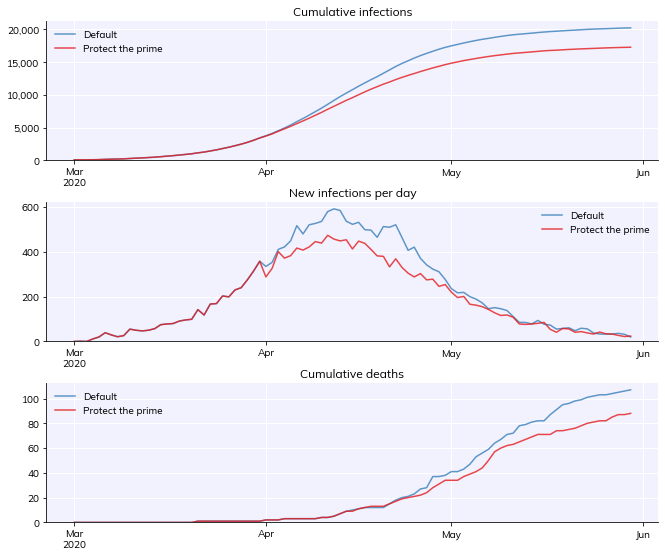

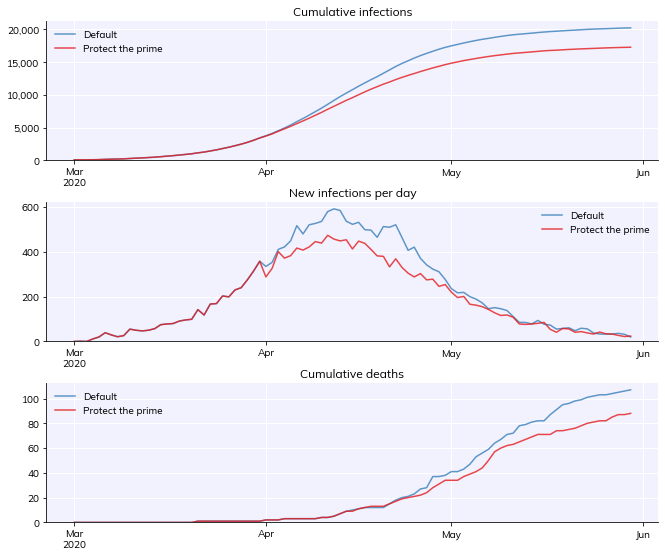

In [3]:
import numpy as np
import sciris as sc
import covasim as cv
from my_interventions import *

#def protect_the_prime(sim):
#    if sim.t == sim.day('2020-04-01'):
#        are_prime = sim.people.prime
#        sim.people.rel_sus[are_prime] = 0.0

pars = dict(
    pop_type = 'hybrid',
    pop_infected = 100,
    n_days = 90,
    verbose = 0,
)

# Default simulation
orig_sim = cv.Sim(pars, label='Default')

# Create the simulation
sim = cv.Sim(pars, label='Protect the prime', interventions=protect_the_prime)
sim.initialize() # Initialize to create the people array
sim.people.prime = np.array([sc.isprime(i) for i in range(len(sim.people))]) # Define whom to target

# Run and plot
msim = cv.parallel(orig_sim, sim)
msim.plot()

## Changing Numba options

Finally, this example shows how you can change the default Numba calculation options. It's not recommended – especially running with multithreading, which is faster but gives stochastically unreproducible results – but it's there if you want it.

Sim("32-bit, single-threaded (default)"; 2020-03-01 to 2020-04-30; pop: 20000 random; epi: 12730⚙, 14☠)
Reloading Covasim so changes take effect...
Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM
Reload complete. Note: for some options to take effect, you may also need to delete Covasim's __pycache__ folder.
Sim("64-bit, single-threaded"; 2020-03-01 to 2020-04-30; pop: 20000 random; epi: 13209⚙, 16☠)
Reloading Covasim so changes take effect...
Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM
Reload complete. Note: for some options to take effect, you may also need to delete Covasim's __pycache__ folder.
Sim("64-bit, multi-threaded"; 2020-03-01 to 2020-04-30; pop: 20000 random; epi: 13209⚙, 16☠)
Reloading Covasim so changes take effect...
Covasim 3.1.4 (2022-10-22) — © 2020-2022 by IDM
Reload complete. Note: for some options to take effect, you may also need to delete Covasim's __pycache__ folder.
Sim("32-bit, single-threaded (restored)"; 2020-03-01 to 2020-04-30; pop: 20000 random; epi:

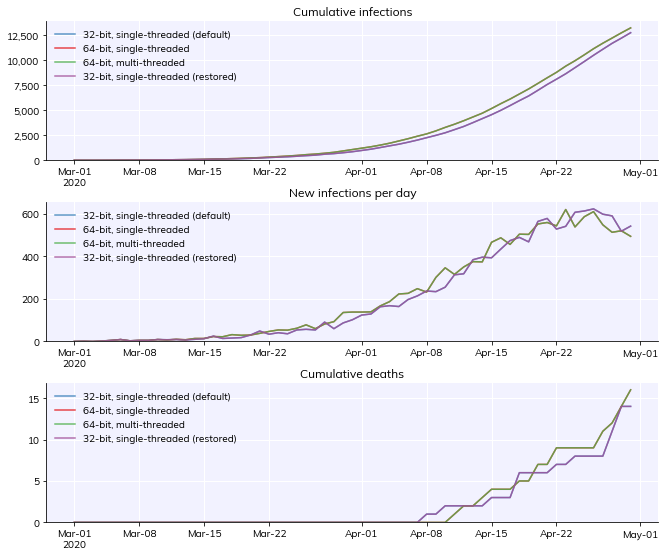

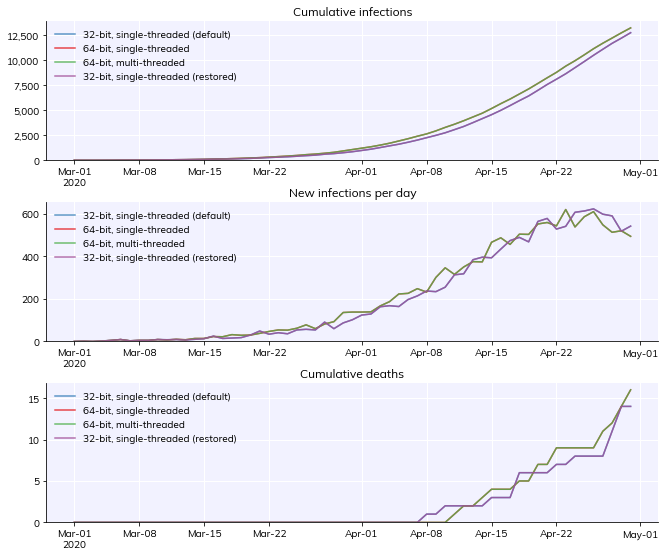

In [4]:
import covasim as cv

# Create a standard 32-bit simulation
sim32 = cv.Sim(label='32-bit, single-threaded (default)', verbose='brief')
sim32.run()

# Use 64-bit instead of 32
cv.options.set(precision=64)
sim64 = cv.Sim(label='64-bit, single-threaded', verbose='brief')
sim64.run()

# Use parallel threading
cv.options.set(numba_parallel=True)
sim_par = cv.Sim(label='64-bit, multi-threaded', verbose='brief')
sim_par.run()

# Reset to defaults
cv.options.set('defaults')
sim32b = cv.Sim(label='32-bit, single-threaded (restored)', verbose='brief')
sim32b.run()

# Plot
msim = cv.MultiSim([sim32, sim64, sim_par, sim32b])
msim.plot()